# Stock Prediction using LSTM

For this project, we focused on predicting stock prices with the integration of sentiment analysis. The rationale behind this approach is that news, tweets, and social media activity significantly influence the movement of a company's stock price. By incorporating sentiment analysis, we aim to capture these external factors to enhance the accuracy of our predictions.

We selected **Apple Inc. (AAPL)** as the stock of interest. We also found an open-source dataset accumulating sentiments for different stocks over a period of 365 days i.e. \(2019 - 2020). https://github.com/adlnlp/StockEmotions?utm_source=chatgpt.com

## Approaches
We explored some distinct approaches for this project:

1. **Stock Price Prediction Using Time-Series**

  Using historical stock price data to predict future prices using time-series modeling.

1. **Stock Price Prediction Using LSTM \(Without Sentiment Analysis)**  
   Using historical stock price data alone to predict future prices.

2. **Stock Price Prediction Using LSTM \(With Sentiment Analysis)**  
   Combining historical stock data with sentiment scores derived from news and social media to potentially improve predictions.

## Methodology

For both latter approaches, we utilized a Long Short-Term Memory (LSTM) neural network. We first used a normal LSTM but then improved upon it and got better results.

## Steps
1. **Data Collection**:
   - Historical stock price data for AAPL.
   - Sentiment data derived from news articles, tweets, and social media posts related to Apple.

2. **Data Preprocessing**:
   - Normalizing stock price data for LSTM input.
   - Assigning sentiment scores for either a Bullish or a Bearish trend.

3. **Model Training**:
   - Training a normal sequential model using time-series modeling.
   - Training the LSTM model on historical stock data for the second approach.
   - Incorporating sentiment scores alongside stock data for the third approach.

4. **Evaluation**:
   - Comparing the performance of the three models to assess the impact of sentiment analysis on prediction accuracy.



In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

import tensorflow as tf
import yfinance as yf
from datetime import date
from IPython.display import Image
from matplotlib.animation import FuncAnimation
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

## Getting the stock data from Yahoo Finance


In [ ]:
# setting start date and end date
start_date = '2020-01-01'
end_date = date.today().strftime("%Y-%m-%d")

# taking APPLE stock data from yahoo finance module
df = yf.download('AAPL', start=start_date, end=end_date)

df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02,72.796028,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.088295,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.662712,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.320992,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.484352,75.797501,76.110001,74.290001,74.290001,132079200
...,...,...,...,...,...,...
2024-12-09,246.750000,246.750000,247.240005,241.750000,241.830002,44649200
2024-12-10,247.770004,247.770004,248.210007,245.339996,246.889999,36914800


In [ ]:
df.columns = df.columns.get_level_values(0)

df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

## Visualizing the data

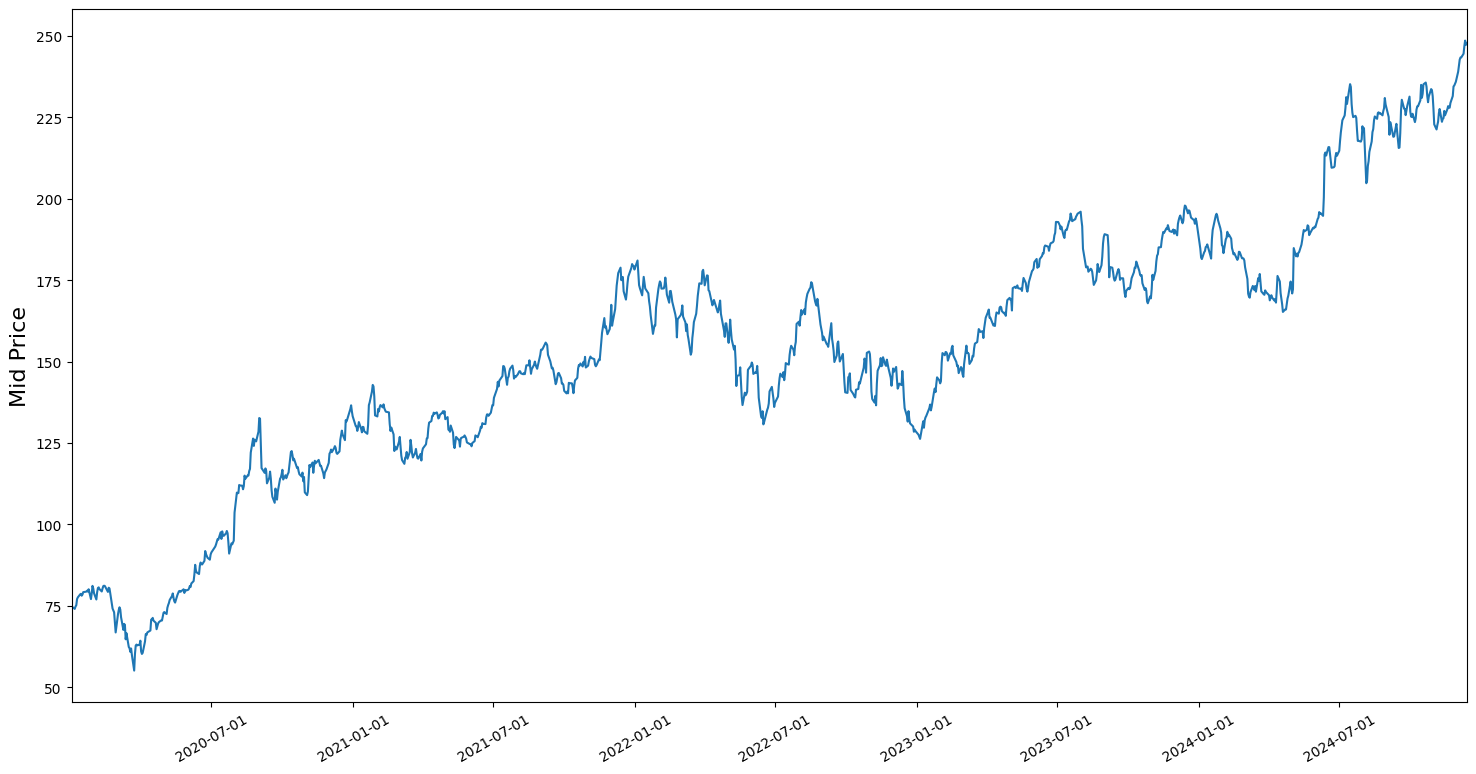

In [ ]:
# plotting the mid price over time
fig, ax1 = plt.subplots(1, 1, figsize=(18, 9))


mid_price = (df['Low'] + df['High']) / 2.0
ax1.plot(df.index, mid_price, '-', markersize=4)

ax1.set_xlim(df.index.min(), df.index.max())

ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax1.set_ylabel('Mid Price', fontsize=16)

plt.show()

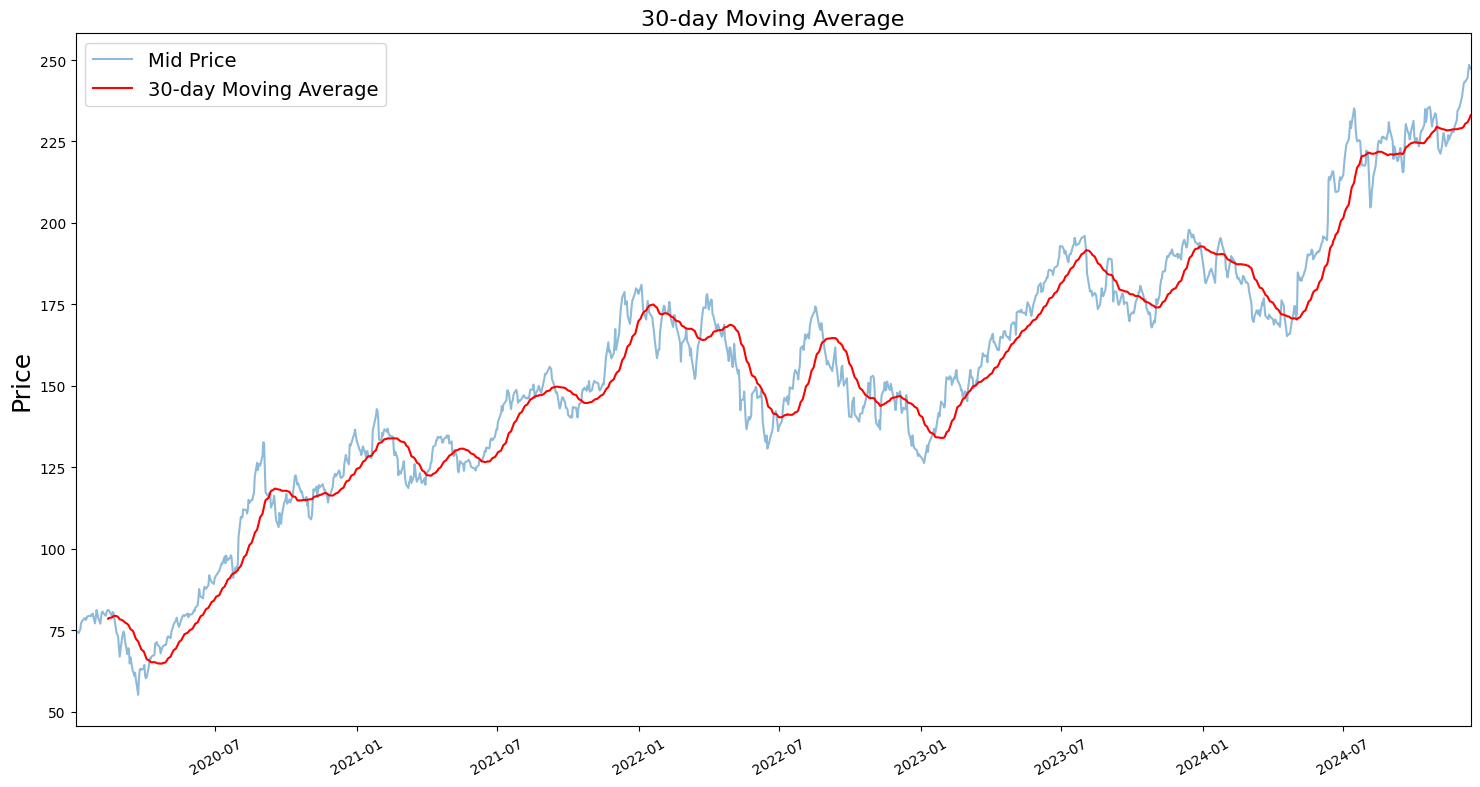

In [ ]:
# calc the mid price and the rolling mean
mid_price = (df['Low'] + df['High']) / 2.0
rolling_mean = mid_price.rolling(window=30).mean()

plt.figure(figsize=(18, 9))
plt.plot(df.index, mid_price, label='Mid Price', alpha=0.5)
plt.plot(df.index, rolling_mean, label='30-day Moving Average', color='red')

plt.xlim(df.index.min(), df.index.max())

plt.ylabel('Price', fontsize=18)
plt.legend(fontsize=14)
plt.title('30-day Moving Average', fontsize=16)

plt.xticks(rotation=30)

plt.show()

In [ ]:
# normalize the 'close' column
df['Close'] = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())

In [ ]:
close_prices = df['Close']

# splitting for training
train_size = int(len(close_prices) * 0.7)
valid_size = int(len(close_prices) * 0.2)

train_data = close_prices[:train_size]
valid_data = close_prices[train_size:train_size + valid_size]
test_data = close_prices[train_size + valid_size:]

print(f"Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")


Train: 872, Valid: 249, Test: 126


In [ ]:
train_data

,Close
Date,
2020-01-02,0.098913
2020-01-03,0.095112
2020-01-06,0.098197
2020-01-07,0.096361
2020-01-08,0.102610
...,...
2023-06-13,0.662462
2023-06-14,0.665794
2023-06-15,0.676521


## Creating Datasets and Dataloader


In [ ]:
import numpy as np

X_train = []
y_train = []

seq_length = 60

target_column_index = 4

for i in range(len(train_data) - seq_length):
    X_train.append(train_data[i:i + seq_length])
    y_train.append(train_data[i + seq_length])

# converting to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)

<ipython-input-45-ec43167b1f52>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train.append(train_data[i + seq_length])


In [ ]:
# creating datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_dataset[0]

(tensor([0.0989, 0.0951, 0.0982, 0.0964, 0.1026, 0.1110, 0.1119, 0.1205, 0.1150,
         0.1132, 0.1183, 0.1228, 0.1200, 0.1215, 0.1235, 0.1223, 0.1101, 0.1215,
         0.1301, 0.1295, 0.1108, 0.1097, 0.1230, 0.1264, 0.1313, 0.1245, 0.1265,
         0.1240, 0.1339, 0.1308, 0.1309, 0.1232, 0.1292, 0.1249, 0.1154, 0.0961,
         0.0829, 0.0889, 0.0640, 0.0638, 0.0969, 0.0846, 0.1020, 0.0892, 0.0842,
         0.0544, 0.0794, 0.0665, 0.0311, 0.0698, 0.0232, 0.0371, 0.0290, 0.0266,
         0.0063, 0.0000, 0.0293, 0.0275, 0.0444, 0.0304]),
 tensor([0.0396]))

In [ ]:
import numpy as np

X_valid = []
y_valid = []

seq_length = 60
target_column_index = 4

for i in range(len(valid_data) - seq_length):
    X_valid.append(valid_data[i:i + seq_length])
    y_valid.append(valid_data[i + seq_length])

# Convert to numpy arrays
X_valid = np.array(X_valid)
y_valid = np.array(y_valid).reshape(-1, 1)

print(f"Feature Shape: {X_valid.shape}")
print(X_valid[:2])

print(f"\nTarget Shape: {y_valid.shape}")
print(y_valid[:2])

Feature Shape: (189, 60)
[[0.66584653 0.68167674 0.68001036 0.67266811 0.68719648 0.6933932
  0.69516367 0.71797174 0.71010872 0.70422443 0.70672392 0.70083963
  0.69006052 0.68730065 0.69610103 0.7001106  0.70089175 0.71807591
  0.71672196 0.72385603 0.71359761 0.70740089 0.71161881 0.71614915
  0.72073161 0.71406625 0.72765735 0.73088586 0.72651174 0.71073357
  0.70339124 0.65558812 0.63923715 0.64418408 0.6358003  0.63465468
  0.63371732 0.64241361 0.63194686 0.62736447 0.61398163 0.61653324
  0.62356307 0.63080124 0.6510577  0.62637507 0.63798736 0.64621493
  0.66667964 0.68506146 0.68620708 0.69448677 0.69573648 0.66037884
  0.63251966 0.63574817 0.64189285 0.62595847 0.6150752  0.62304239]
 [0.68167674 0.68001036 0.67266811 0.68719648 0.6933932  0.69516367
  0.71797174 0.71010872 0.70422443 0.70672392 0.70083963 0.69006052
  0.68730065 0.69610103 0.7001106  0.70089175 0.71807591 0.71672196
  0.72385603 0.71359761 0.70740089 0.71161881 0.71614915 0.72073161
  0.71406625 0.72765735

<ipython-input-47-29cef6abc6e9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_valid.append(valid_data[i + seq_length])


In [ ]:
# creating dataloader
X_valid_t = torch.tensor(X_valid, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32)

valid_dataset = TensorDataset(X_valid_t, y_valid_t)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
import numpy as np

X_test = []
y_test = []

seq_length = 60
target_column_index =4

for i in range(len(test_data) - seq_length):
    X_test.append(test_data[i:i + seq_length])
    y_test.append(test_data[i + seq_length])

# converting to numpy
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

print(f"Feature Shape: {X_test.shape}")
print(X_test[:2])

print(f"\nTarget Shape: {y_test.shape}")
print(y_test[:2])

Feature Shape: (66, 60)
[[0.8361778  0.82378436 0.79977863 0.78837468 0.7917594  0.79660225
  0.81836879 0.82279504 0.80467352 0.83659439 0.85492417 0.86158953
  0.88653254 0.89423942 0.89871764 0.92110911 0.89293759 0.90840325
  0.92850349 0.93069064 0.89975916 0.87528472 0.87596169 0.87413918
  0.8796068  0.84591546 0.84044784 0.84289528 0.84435332 0.84726941
  0.8643494  0.84497818 0.85278915 0.79764369 0.78702072 0.80050773
  0.81868121 0.83393869 0.8406561  0.86013149 0.86247476 0.87809671
  0.88502245 0.88418926 0.88741777 0.88684496 0.87710731 0.8891362
  0.89090666 0.89533291 0.88731368 0.90449776 0.90038402 0.86794246
  0.85794442 0.86591161 0.85778821 0.85825685 0.85409098 0.86736965]
 [0.82378436 0.79977863 0.78837468 0.7917594  0.79660225 0.81836879
  0.82279504 0.80467352 0.83659439 0.85492417 0.86158953 0.88653254
  0.89423942 0.89871764 0.92110911 0.89293759 0.90840325 0.92850349
  0.93069064 0.89975916 0.87528472 0.87596169 0.87413918 0.8796068
  0.84591546 0.84044784 0

<ipython-input-49-f2448bc81cb5>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test.append(test_data[i + seq_length])


In [ ]:
#creating loader
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
def train_epoch(data_loader, model, optimizer, loss_function):

    total_loss = 0

    for batch in data_loader:

        X, y = batch

        pred = model(X)

      # calculating loss
        loss = loss_function(pred, y)

    # back prop and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss

## First using a sequential model

We can see that using a sequential model also gives very little loss for simple time-series prediction

In [ ]:

model = nn.Sequential(nn.Linear(seq_length, 1))

loss_function = nn.HuberLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(10):
  # training for 10 epoch
    l = train_epoch(train_loader, model, optimizer, loss_function)
    print(f"{epoch}/10 completed!")

0/10 completed!
1/10 completed!
2/10 completed!
3/10 completed!
4/10 completed!
5/10 completed!
6/10 completed!
7/10 completed!
8/10 completed!
9/10 completed!


In [ ]:
l

0.012467476233723573

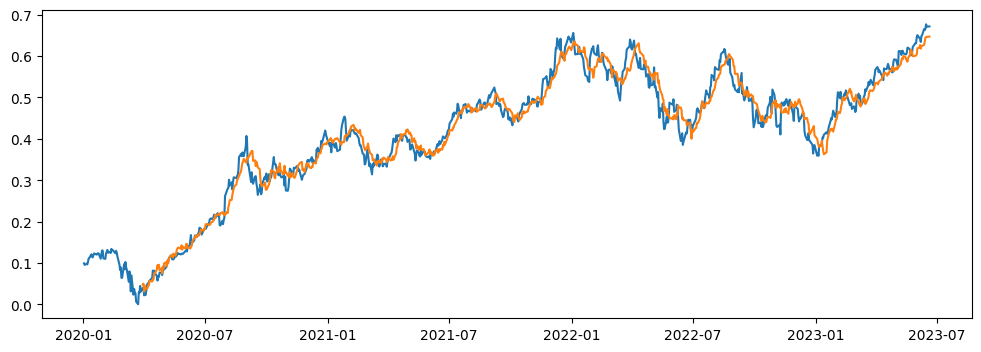

In [ ]:
# plot on training
y_hat = model(X_train_t)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(train_data.index, train_data.to_numpy())
ax1.plot(train_data.iloc[seq_length:].index, y_hat.detach().numpy())

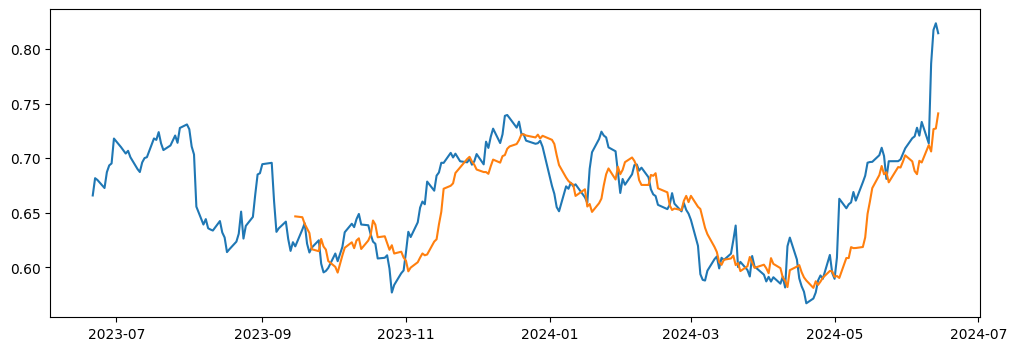

In [ ]:
# plot on valid
y_hat = model(X_valid_t)

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(valid_data.index, valid_data.to_numpy())
ax1.plot(valid_data.iloc[seq_length:].index, y_hat.detach().numpy())

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, output_size=1, num_layers=4, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/20], Training Loss: 0.0887, Validation Loss: 0.0028
Epoch [2/20], Training Loss: 0.0100, Validation Loss: 0.0103
Epoch [3/20], Training Loss: 0.0065, Validation Loss: 0.0058
Epoch [4/20], Training Loss: 0.0049, Validation Loss: 0.0033
Epoch [5/20], Training Loss: 0.0039, Validation Loss: 0.0027
Epoch [6/20], Training Loss: 0.0033, Validation Loss: 0.0024
Epoch [7/20], Training Loss: 0.0029, Validation Loss: 0.0030
Epoch [8/20], Training Loss: 0.0026, Validation Loss: 0.0023
Epoch [9/20], Training Loss: 0.0022, Validation Loss: 0.0013
Epoch [10/20], Training Loss: 0.0019, Validation Loss: 0.0015
Epoch [11/20], Training Loss: 0.0017, Validation Loss: 0.0016
Epoch [12/20], Training Loss: 0.0017, Validation Loss: 0.0048
Epoch [13/20], Training Loss: 0.0014, Validation Loss: 0.0018
Epoch [14/20], Training Loss: 0.0013, Validation Loss: 0.0024
Epoch [15/20], Training Loss: 0.0013, Validation Loss: 0.0054
Epoch [16/20], Training Loss: 0.0012, Validation Loss: 0.0015
Epoch [17/20], Tr

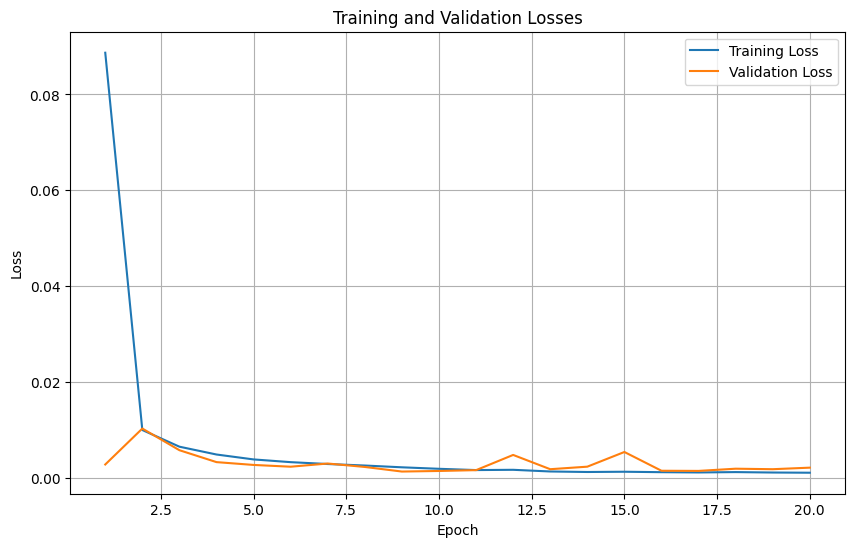

In [ ]:
import torch.optim as optim

model = LSTMModel(input_size=seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# lists to store the loss
train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:

        inputs = inputs.unsqueeze(1)


        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward
        loss.backward()
        optimizer.step()

        # getting the trainign loss
        running_train_loss += loss.item() * inputs.size(0)

    # getting the average training loss
    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)


    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.unsqueeze(1)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # getting the validation loss
            running_val_loss += loss.item() * inputs.size(0)

    # getting the avg validation loss
    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()


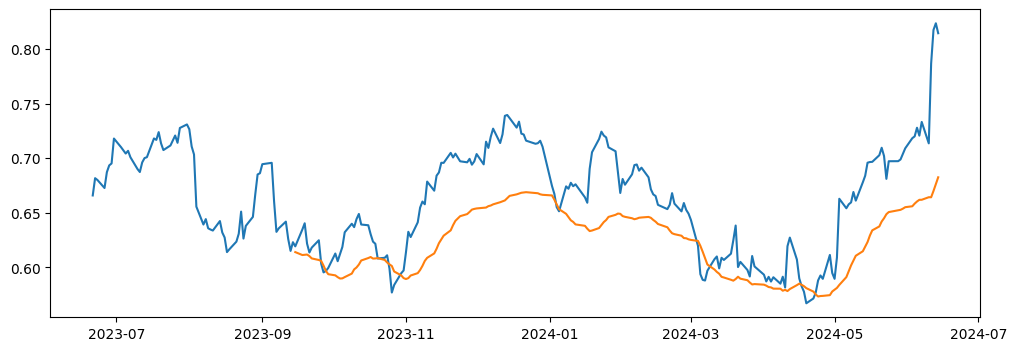

In [ ]:
y_hat = model(X_valid_t.unsqueeze(1))

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(valid_data.index, valid_data.to_numpy())
ax1.plot(valid_data.iloc[seq_length:].index, y_hat.detach().numpy())

## Imporved LSTM Model

Here, instead of taking the normal LSTM we use an imporved versions.
Changes made:

1. Using dropout layer
2. Using Batch normalization
3. Weight Initialization

Then we train the model for 20 epochs and visualize the training and validation loss

After that we visualize the predicted results.

In [ ]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size=100,
                 output_size=1,
                 num_layers=4,
                 dropout_prob=0.1,
                 use_batchnorm=True):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # lstm
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        # including a batch normalization
        self.bn = nn.BatchNorm1d(hidden_size) if use_batchnorm else None

        # fc layer
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x, lengths=None):

        if lengths is not None:
            x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        lstm_out, _ = self.lstm(x)

        if lengths is not None:
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        if lengths is not None:
            last_outputs = lstm_out[torch.arange(lstm_out.size(0)), lengths - 1]
        else:
            last_outputs = lstm_out[:, -1, :]

        if self.bn is not None:
            last_outputs = self.bn(last_outputs)

        out = self.fc_layers(last_outputs)
        return out

Epoch [1/20], Training Loss: 0.0698, Validation Loss: 0.2070
Epoch [2/20], Training Loss: 0.0135, Validation Loss: 0.1769
Epoch [3/20], Training Loss: 0.0088, Validation Loss: 0.1191
Epoch [4/20], Training Loss: 0.0073, Validation Loss: 0.0725
Epoch [5/20], Training Loss: 0.0063, Validation Loss: 0.0586
Epoch [6/20], Training Loss: 0.0061, Validation Loss: 0.0995
Epoch [7/20], Training Loss: 0.0048, Validation Loss: 0.0782
Epoch [8/20], Training Loss: 0.0047, Validation Loss: 0.0358
Epoch [9/20], Training Loss: 0.0042, Validation Loss: 0.0248
Epoch [10/20], Training Loss: 0.0042, Validation Loss: 0.0515
Epoch [11/20], Training Loss: 0.0037, Validation Loss: 0.0221
Epoch [12/20], Training Loss: 0.0035, Validation Loss: 0.0049
Epoch [13/20], Training Loss: 0.0030, Validation Loss: 0.0302
Epoch [14/20], Training Loss: 0.0026, Validation Loss: 0.0069
Epoch [15/20], Training Loss: 0.0025, Validation Loss: 0.0321
Epoch [16/20], Training Loss: 0.0028, Validation Loss: 0.0133
Epoch [17/20], Tr

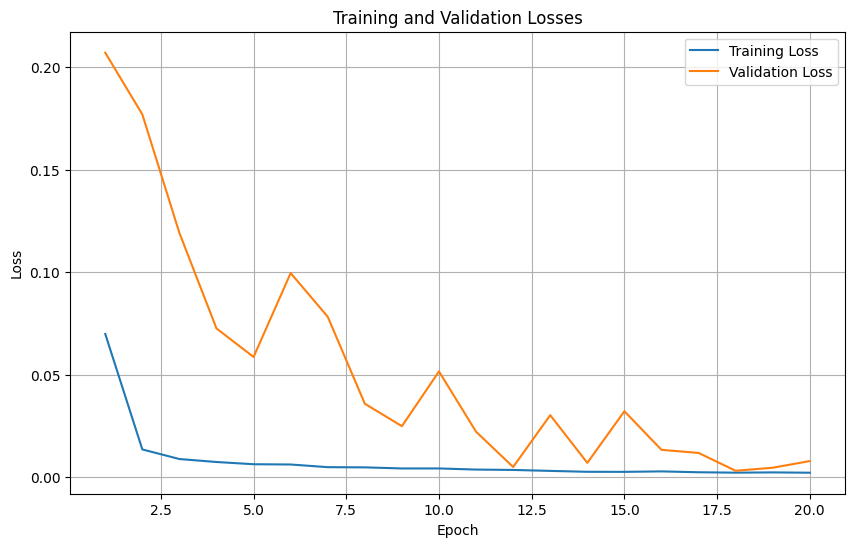

In [ ]:
import torch.optim as optim

model = ImprovedLSTMModel(input_size=seq_length)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# lists to store the loss
train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:

        inputs = inputs.unsqueeze(1)


        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward
        loss.backward()
        optimizer.step()

        # getting the trainign loss
        running_train_loss += loss.item() * inputs.size(0)

    # getting the average training loss
    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)


    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.unsqueeze(1)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # getting the validation loss
            running_val_loss += loss.item() * inputs.size(0)

    # getting the avg validation loss
    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()


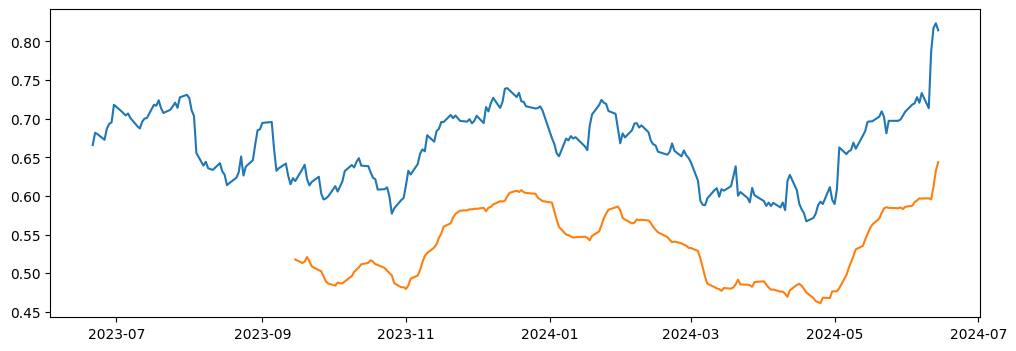

In [ ]:
y_hat = model(X_valid_t.unsqueeze(1))

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(valid_data.index, valid_data.to_numpy())
ax1.plot(valid_data.iloc[seq_length:].index, y_hat.detach().numpy())

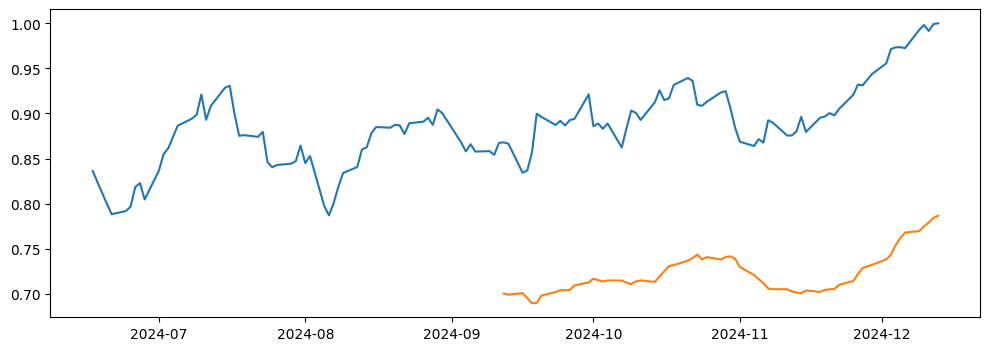

In [ ]:
y_hat = model(X_test_t.unsqueeze(1))

fig, ax1 = plt.subplots(1,1, figsize=(12,4))

ax1.plot(test_data.index, test_data.to_numpy())
ax1.plot(test_data.iloc[seq_length:].index, y_hat.detach().numpy())

## Adding sentiment analysis

Now we will run the imporved LSTM model with sentiment analysis added.
For sentiment analysis we are adding a new column - 0 for bearish and 1 for bullish.

Then using the new dataframe we make predicitons again.


In [ ]:
file_url = "https://drive.google.com/uc?id=1lZX61kj6NpYySDCTwgfAiZ0mtfY1QQAo"
output_file = "processed_stockemo.csv"

import gdown
gdown.download(file_url, output_file, quiet=False)

# now adding sentiment analysis
sentiment_df = pd.read_csv("/content/processed_stockemo.csv")
sentiment_df

Downloading...
From: https://drive.google.com/uc?id=1lZX61kj6NpYySDCTwgfAiZ0mtfY1QQAo
To: /content/processed_stockemo.csv
100%|██████████| 13.8M/13.8M [00:00<00:00, 33.8MB/s]


,id,date,ticker,senti_label,original,processed,industry
0,0,2020-08-31,AAPL,Bullish,$AAPL you better get back to $130 again 🤔,AAPL you better get back to again thinking face,Information Technology
1,1,2020-08-31,AAPL,Bullish,$AAPL now we just wait for power hour 😎💪🏾,AAPL now we just wait for power hour smiling f...,Information Technology
2,2,2020-08-31,AAPL,Bullish,$AAPL never thought I'd buy this 💰,AAPL never thought I d buy this money bag,Information Technology
3,3,2020-08-31,AAPL,Bullish,$AAPL bought my first option ever with Apple f...,AAPL bought my first option ever with Apple fo...,Information Technology
4,4,2020-08-31,AAPL,Bullish,"$AAPL Buy low, hold for another split in a cou...",AAPL Buy low hold for another split in a coupl...,Information Technology
...,...,...,...,...,...,...,...
50276,50276,2020-10-08,LOW,Bullish,$LOW Why isn’t this trending yet 🤔,LOW Why isn t this trending yet thinking face,Consumer Discretionary
50277,50277,2020-10-08,LOW,Bullish,$LOW Show us some strength and push over $170‼️,LOW Show us some strength and push over double...,Consumer Discretionary
50278,50278,2020-11-11,LOW,Bullish,$LOW retail investors will keep adding until ...,LOW retail investors will keep adding until ea...,Consumer Discretionary
50279,50279,2020-12-09,LOW,Bullish,$LOW in 10mins Squeeze Zone possible morning s...,LOW in mins Squeeze Zone possible morning spik...,Consumer Discretionary


In [ ]:
import re

def tokenizer(text):
    text = re.sub(r'[^\w\s.]', '', text)
    text = text.replace('.', ' . ')

    text = text.lower()
    tokens = text.split()
    return tokens

In [ ]:
sentiment_df['processed'][0]

'AAPL you better get back to again thinking face'

In [ ]:
print(tokenizer(sentiment_df['processed'][0]))

['aapl', 'you', 'better', 'get', 'back', 'to', 'again', 'thinking', 'face']


In [ ]:
def build_vocab(corpus):
    vocab = {}
    vocab_reversed = {}
    idx = 0

    for doc in corpus:
        for word in doc.split():
            if word not in vocab:
                vocab[word] = idx
                vocab_reversed[idx] = word
                idx += 1

    vocab_len = len(vocab)
    return vocab, vocab_reversed, vocab_len

In [ ]:
vocab, vocab_reversed, vocab_len = build_vocab(sentiment_df['processed'].tolist())

In [ ]:
vocab_len

27328

In [ ]:
def vectorize_bow(corpus, vocab, tokenizer):
    vectors = np.zeros((len(corpus), len(vocab)))

    for i, doc in enumerate(corpus):
        tokens = tokenizer(doc)
        for token in tokens:
            if token in vocab:
                vectors[i][vocab[token]] += 1

    return vectors

In [ ]:
bow_vectors = vectorize_bow(sentiment_df['processed'].tolist(), vocab, tokenizer)
print("Bag-of-Words Vectors:\n", bow_vectors)

Bag-of-Words Vectors:
 [[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def vectorize_tfidf(corpus, vocab, tokenizer):
    bow_vectors = vectorize_bow(corpus, vocab, tokenizer)
    tf = bow_vectors / np.maximum(1, np.sum(bow_vectors, axis=1, keepdims=True))

    df = np.count_nonzero(bow_vectors > 0, axis=0)


    total_docs = len(corpus)
    idf = np.log((1 + total_docs) / (1 + df)) + 1

    #computing the tfidf
    tfidf = tf * idf
    return tfidf


In [ ]:
tfidf_vectors = vectorize_tfidf(sentiment_df['processed'].tolist(), vocab, tokenizer)
print("TF-IDF Vectors:\n", tfidf_vectors)

TF-IDF Vectors:
 [[0.         0.34627028 0.61885027 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
X = sentiment_df['processed'].tolist()
y = sentiment_df['senti_label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# test train split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# x train tfidf
X_train_tfidf = vectorize_tfidf(X_train, vocab, tokenizer)
X_val_tfidf = vectorize_tfidf(X_val, vocab, tokenizer)
X_test_tfidf = vectorize_tfidf(X_test, vocab, tokenizer)


model = LogisticRegression(class_weight='balanced')
model.fit(X_train_tfidf, y_train)

y_val_pred = model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

y_test_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.8024396711747547
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.75      0.50      1014
           1       0.95      0.81      0.88      6528

    accuracy                           0.80      7542
   macro avg       0.67      0.78      0.69      7542
weighted avg       0.88      0.80      0.83      7542

Test Accuracy: 0.8036590216094393
Test Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.74      0.50      1015
           1       0.95      0.81      0.88      6528

    accuracy                           0.80      7543
   macro avg       0.67      0.78      0.69      7543
weighted avg       0.88      0.80      0.83      7543



In [ ]:
# example texts for testing
new_texts = [
    "Tesla is skyrocketing!",
    "The market is crashing badly.",
    "I am optimistic about the future of the tech sector.",
    "The recent stock performance has been disappointing.",
    "What a great day for investors in Tesla!",
    "Massive layoffs announced; the economy is in trouble.",
    "Stock prices have been stable this week.",
    "Why is this stock underperforming? Terrible results!",
    "The company's growth trajectory looks promising.",
    "Investors are panicking due to the latest financial report."
]

# processing and prediction
new_vectors = vectorize_tfidf(new_texts, vocab, tokenizer)

predictions = model.predict(new_vectors)

predicted_labels = label_encoder.inverse_transform(predictions)


for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: Tesla is skyrocketing!
Predicted Sentiment: Bullish

Text: The market is crashing badly.
Predicted Sentiment: Bearish

Text: I am optimistic about the future of the tech sector.
Predicted Sentiment: Bearish

Text: The recent stock performance has been disappointing.
Predicted Sentiment: Bullish

Text: What a great day for investors in Tesla!
Predicted Sentiment: Bullish

Text: Massive layoffs announced; the economy is in trouble.
Predicted Sentiment: Bullish

Text: Stock prices have been stable this week.
Predicted Sentiment: Bearish

Text: Why is this stock underperforming? Terrible results!
Predicted Sentiment: Bearish

Text: The company's growth trajectory looks promising.
Predicted Sentiment: Bullish

Text: Investors are panicking due to the latest financial report.
Predicted Sentiment: Bullish



In [ ]:
apple_df = sentiment_df[sentiment_df['ticker'] == 'AAPL']

new_vectors = vectorize_tfidf(apple_df['processed'].tolist(), vocab, tokenizer)

#predicitng
predictions = model.predict(new_vectors)

# getting the original labels
predicted_labels = label_encoder.inverse_transform(predictions)

predicted_labels

array(['Bearish', 'Bullish', 'Bullish', ..., 'Bullish', 'Bullish',
       'Bearish'], dtype=object)

In [ ]:
len(predicted_labels)

8904

In [ ]:
apple_df = sentiment_df[sentiment_df['ticker'] == 'AAPL']

new_end_date = max(apple_df["date"])
new_start_date = min(apple_df["date"])

apple_df['date'] = pd.to_datetime(apple_df['date'])

filtered_df = apple_df[(apple_df['date'] >= new_start_date) & (apple_df['date'] <= new_end_date)]

result_df = (
    filtered_df.groupby('date')['senti_label']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)
result_df.columns = ['date', 'most_common_sentiment']

result_df

<ipython-input-79-ded7530c2f06>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['date'] = pd.to_datetime(apple_df['date'])


,date,most_common_sentiment
0,2019-12-31,Bullish
1,2020-01-01,Bullish
2,2020-01-02,Bullish
3,2020-01-03,Bullish
4,2020-01-05,Bullish
...,...,...
333,2020-12-27,Bullish
334,2020-12-28,Bullish
335,2020-12-29,Bullish
336,2020-12-30,Bearish


In [ ]:
result_df["date"].nunique()


338

In [ ]:
new_df = yf.download('AAPL', start=new_start_date, end=new_end_date)

new_df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-12-31,71.172127,73.412498,73.419998,72.379997,72.482498,100805600
2020-01-02,72.796005,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.088287,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.662704,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000
...,...,...,...,...,...,...
2020-12-23,128.059891,130.960007,132.429993,130.779999,132.160004,88223700
2020-12-24,129.047516,131.970001,133.460007,131.100006,131.320007,54930100


In [ ]:
filtered_result_df = result_df[result_df['date'].isin(new_df.index)]

filtered_result_df

,date,most_common_sentiment
0,2019-12-31,Bullish
2,2020-01-02,Bullish
3,2020-01-03,Bullish
5,2020-01-06,Bullish
6,2020-01-07,Bullish
...,...,...
329,2020-12-23,Bullish
330,2020-12-24,Bullish
334,2020-12-28,Bullish
335,2020-12-29,Bullish


In [ ]:
new_df['senti_label'] = None

# converting to datetime
filtered_result_df['date'] = pd.to_datetime(filtered_result_df['date'])
filtered_result_df.set_index('date', inplace=True)

# Assigning sentitment analysis
for date in new_df.index:
    if date in filtered_result_df.index:
        new_df.at[date, 'senti_label'] = filtered_result_df.loc[date, 'most_common_sentiment']

# displaying the dataframe
new_df

<ipython-input-83-e47a876f1bf5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df['date'] = pd.to_datetime(filtered_result_df['date'])


Price,Adj Close,Close,High,Low,Open,Volume,senti_label
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2019-12-31,71.172127,73.412498,73.419998,72.379997,72.482498,100805600,Bullish
2020-01-02,72.796005,75.087502,75.150002,73.797501,74.059998,135480400,Bullish
2020-01-03,72.088287,74.357498,75.144997,74.125000,74.287498,146322800,Bullish
2020-01-06,72.662704,74.949997,74.989998,73.187500,73.447502,118387200,Bullish
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000,Bullish
...,...,...,...,...,...,...,...
2020-12-23,128.059891,130.960007,132.429993,130.779999,132.160004,88223700,Bullish
2020-12-24,129.047516,131.970001,133.460007,131.100006,131.320007,54930100,Bullish


In [ ]:
# creating a new coloumn where Bullish = 0 and Bearish = 1
new_df['senti_binary'] = new_df['senti_label'].apply(lambda x: 0 if x == 'Bullish' else (1 if x == 'Bearish' else None))

new_df

Price,Adj Close,Close,High,Low,Open,Volume,senti_label,senti_binary
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2019-12-31,71.172127,73.412498,73.419998,72.379997,72.482498,100805600,Bullish,0
2020-01-02,72.796005,75.087502,75.150002,73.797501,74.059998,135480400,Bullish,0
2020-01-03,72.088287,74.357498,75.144997,74.125000,74.287498,146322800,Bullish,0
2020-01-06,72.662704,74.949997,74.989998,73.187500,73.447502,118387200,Bullish,0
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000,Bullish,0
...,...,...,...,...,...,...,...,...
2020-12-23,128.059891,130.960007,132.429993,130.779999,132.160004,88223700,Bullish,0
2020-12-24,129.047516,131.970001,133.460007,131.100006,131.320007,54930100,Bullish,0


In [ ]:
new_df.drop("senti_label", axis=1, inplace=True)

new_df

Price,Adj Close,Close,High,Low,Open,Volume,senti_binary
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2019-12-31,71.172127,73.412498,73.419998,72.379997,72.482498,100805600,0
2020-01-02,72.796005,75.087502,75.150002,73.797501,74.059998,135480400,0
2020-01-03,72.088287,74.357498,75.144997,74.125000,74.287498,146322800,0
2020-01-06,72.662704,74.949997,74.989998,73.187500,73.447502,118387200,0
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000,0
...,...,...,...,...,...,...,...
2020-12-23,128.059891,130.960007,132.429993,130.779999,132.160004,88223700,0
2020-12-24,129.047516,131.970001,133.460007,131.100006,131.320007,54930100,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# apply minmax scaling normalization
scaler = MinMaxScaler()

numerical_columns = new_df.select_dtypes(include=['float64', 'int64']).columns

new_df[numerical_columns] = scaler.fit_transform(new_df[numerical_columns])

new_df

Price,Adj Close,Close,High,Low,Open,Volume,senti_binary
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2019-12-31,0.210508,0.214895,0.199535,0.236828,0.190824,0.142474,0.0
2020-01-02,0.231023,0.235677,0.220719,0.254288,0.210292,0.233767,0.0
2020-01-03,0.222082,0.226620,0.220658,0.258322,0.213100,0.262313,0.0
2020-01-06,0.229339,0.233971,0.218760,0.246774,0.202734,0.188763,0.0
2020-01-07,0.225022,0.229598,0.221637,0.261340,0.221399,0.163712,0.0
...,...,...,...,...,...,...,...
2020-12-23,0.929212,0.928906,0.922121,0.956151,0.927311,0.109348,0.0
2020-12-24,0.941689,0.941437,0.934734,0.960092,0.916944,0.021691,0.0


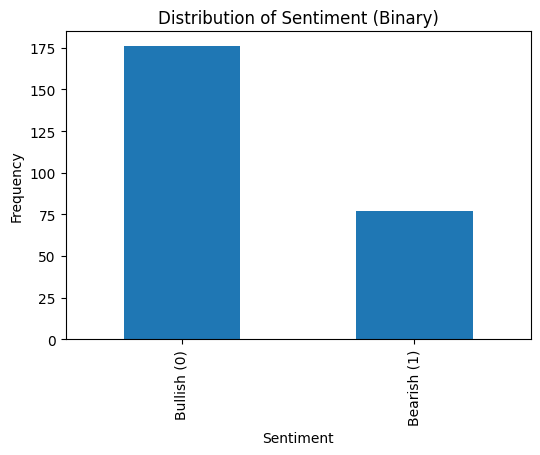

In [ ]:
if 'senti_binary' in new_df.columns:
  # displaying the distribution of bearish and bullish
    plt.figure(figsize=(6, 4))
    new_df['senti_binary'].value_counts().plot(kind='bar')
    plt.title('Distribution of Sentiment (Binary)')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.xticks([0, 1], labels=['Bullish (0)', 'Bearish (1)'])
    plt.show()


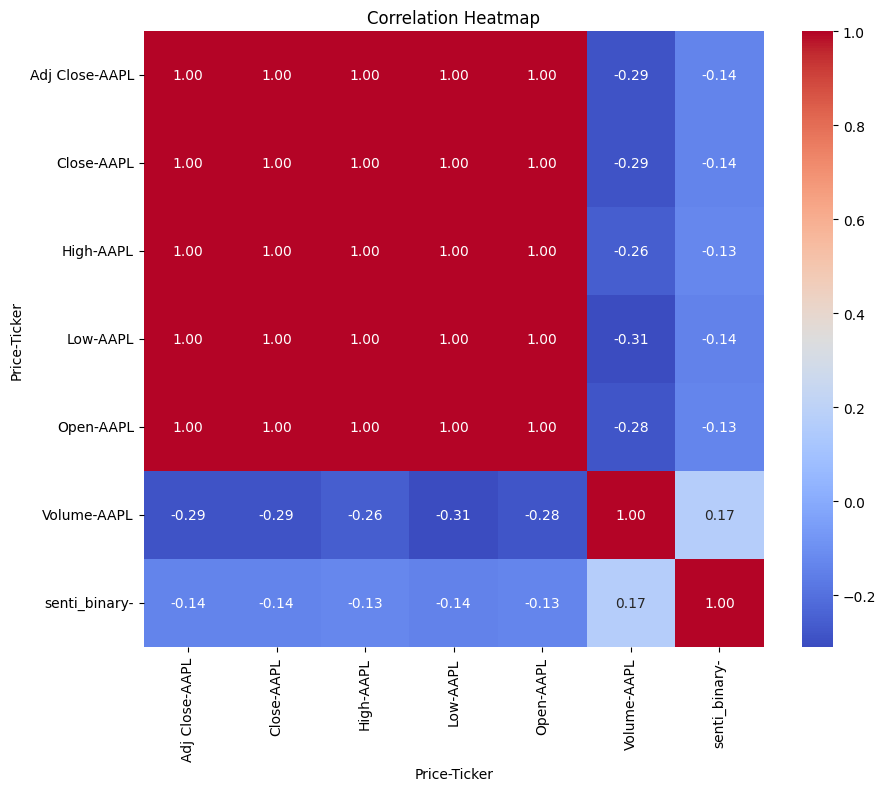

In [ ]:

plt.figure(figsize=(10, 8))
sns.heatmap(new_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
total_length = len(new_df)

# defining the train test split
train_size = int(total_length * 0.7)
valid_size = int(total_length * 0.2)

train_set = new_df.iloc[:train_size]
valid_set = new_df.iloc[train_size:train_size + valid_size]
test_set = new_df.iloc[train_size + valid_size:]


print(f"Train: {len(train_set)}, Valid: {len(valid_set)}, Test: {len(test_set)}")


Train: 177, Valid: 50, Test: 26


In [ ]:
def prepare_sequence_data(
    train_set,
    seq_length=20,
    batch_size=32,
    shuffle=True,
    drop_last=False
):


# using the close column for prediciton
    all_columns = train_set.columns
    target_column = 'Close'


    # Convert to numpy arrays
    features_array = train_set.values
    target_array = train_set[target_column].values

    X_train = []
    y_train = []

    for i in range(len(features_array) - seq_length):
        X_train.append(features_array[i:i + seq_length])
        y_train.append(target_array[i + seq_length])


    X_train = np.array(X_train)
    y_train = np.array(y_train)


    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)


    dataset = TensorDataset(X_tensor, y_tensor)

    # Create DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last
    )

    print(f"Input Sequence Shape: {X_tensor.shape}")
    print(f"Target Shape: {y_tensor.shape}")
    print(f"Number of Batches: {len(dataloader)}")

    return X_tensor, y_tensor, dataloader

In [ ]:
X_train_t, y_train_t, train_loader = prepare_sequence_data(train_set)
X_valid_t, y_valid_t, valid_loader = prepare_sequence_data(valid_set, shuffle=False)

Input Sequence Shape: torch.Size([157, 20, 7])
Target Shape: torch.Size([157, 1])
Number of Batches: 5
Input Sequence Shape: torch.Size([30, 20, 7])
Target Shape: torch.Size([30, 1])
Number of Batches: 1


Using device: cuda


Epoch [1/30] - Training Loss: 0.3019 | Validation Loss: 0.7079


Epoch [2/30] - Training Loss: 0.1305 | Validation Loss: 0.6566


Epoch [3/30] - Training Loss: 0.0640 | Validation Loss: 0.6163


Epoch [4/30] - Training Loss: 0.0481 | Validation Loss: 0.5799


Epoch [5/30] - Training Loss: 0.0419 | Validation Loss: 0.5510


Epoch [6/30] - Training Loss: 0.0320 | Validation Loss: 0.5206


Epoch [7/30] - Training Loss: 0.0217 | Validation Loss: 0.5139


Epoch [8/30] - Training Loss: 0.0302 | Validation Loss: 0.4955


Epoch [9/30] - Training Loss: 0.0238 | Validation Loss: 0.4852


Epoch [10/30] - Training Loss: 0.0213 | Validation Loss: 0.4780


Epoch [11/30] - Training Loss: 0.0159 | Validation Loss: 0.4668


Epoch [12/30] - Training Loss: 0.0307 | Validation Loss: 0.4490


Epoch [13/30] - Training Loss: 0.0137 | Validation Loss: 0.4268


Epoch [14/30] - Training Loss: 0.0156 | Validation Loss: 0.3931


Epoch [15/30] - Training Loss: 0.0137 | Validation Loss: 0.3433


Epoch [16/30] - Training Loss: 0.0142 | Validation Loss: 0.2970


Epoch [17/30] - Training Loss: 0.0191 | Validation Loss: 0.2124


Epoch [18/30] - Training Loss: 0.0131 | Validation Loss: 0.1085


Epoch [19/30] - Training Loss: 0.0151 | Validation Loss: 0.0375


Epoch [20/30] - Training Loss: 0.0187 | Validation Loss: 0.0049


Epoch [21/30] - Training Loss: 0.0164 | Validation Loss: 0.0023


Epoch [22/30] - Training Loss: 0.0189 | Validation Loss: 0.0076


Epoch [23/30] - Training Loss: 0.0195 | Validation Loss: 0.0097


Epoch [24/30] - Training Loss: 0.0133 | Validation Loss: 0.0055


Epoch [25/30] - Training Loss: 0.0138 | Validation Loss: 0.0268


Epoch [26/30] - Training Loss: 0.0155 | Validation Loss: 0.0280


Epoch [27/30] - Training Loss: 0.0155 | Validation Loss: 0.0479


Epoch [28/30] - Training Loss: 0.0123 | Validation Loss: 0.0139


Epoch [29/30] - Training Loss: 0.0145 | Validation Loss: 0.0137


Epoch [30/30] - Training Loss: 0.0195 | Validation Loss: 0.0175


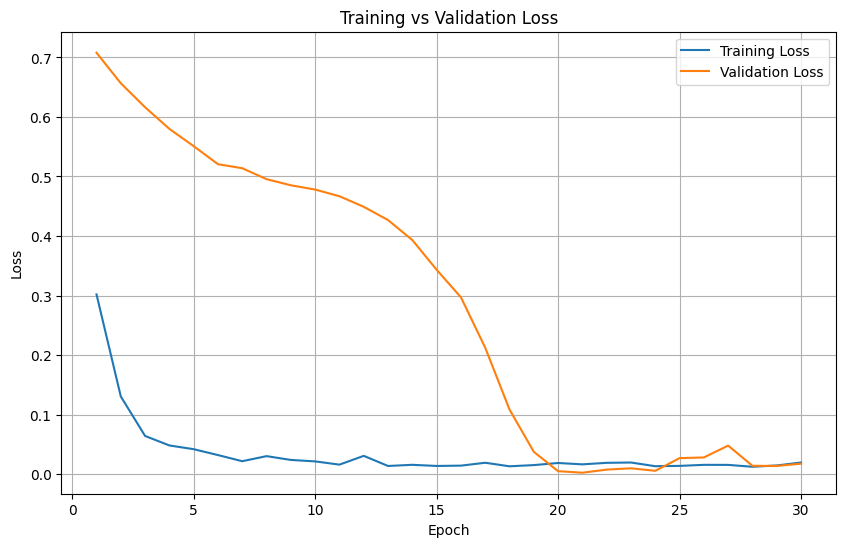

In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# definign the model
model = ImprovedLSTMModel(
    input_size= len(train_set.columns),
    hidden_size=100,
    output_size=1,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# training for 30 epochs
epochs = 30
train_losses = []
valid_losses = []

for epoch in range(1, epochs + 1):

    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)


    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_valid_loss += val_loss.item()

    epoch_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)

    print(f"Epoch [{epoch}/{epochs}] - Training Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_valid_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

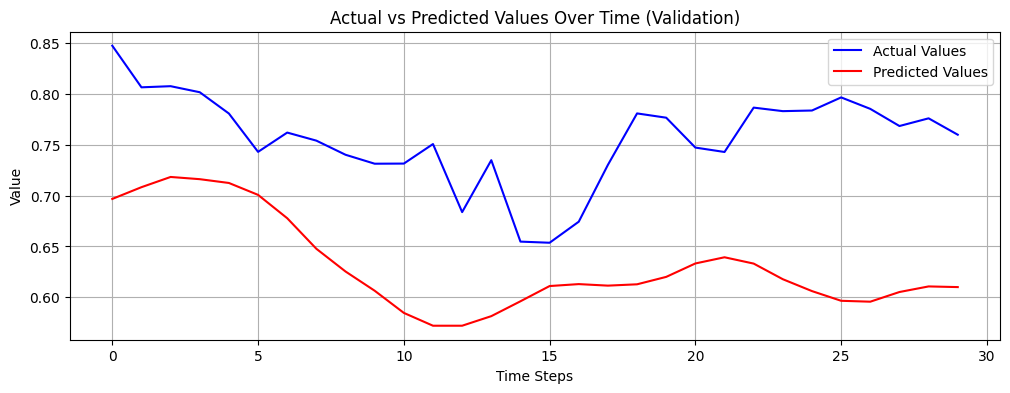

In [ ]:
model.eval()

val_preds = []
val_actuals = []

with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        actual_values = targets.cpu().numpy()
        predicted_values = outputs.squeeze().cpu().numpy()

        val_preds.extend(predicted_values)
        val_actuals.extend(actual_values)

val_preds = np.array(val_preds)
val_actuals = np.array(val_actuals)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(val_actuals, color='blue', label='Actual Values')
plt.plot(val_preds, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values Over Time (Validation)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


Input Sequence Shape: torch.Size([157, 20, 7])
Target Shape: torch.Size([157, 1])
Number of Batches: 5


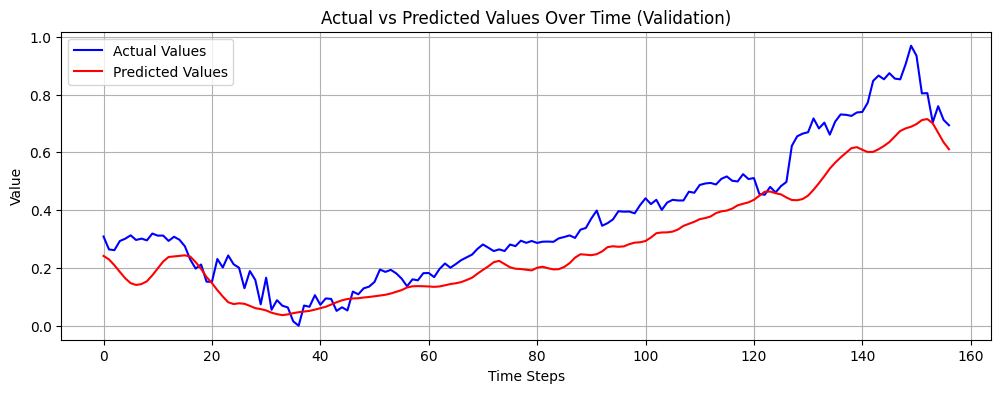

In [ ]:
X_test_t, y_test_t, test_loader = prepare_sequence_data(train_set, shuffle=False)

model.eval()

val_preds = []
val_actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        actual_values = targets.cpu().numpy()
        predicted_values = outputs.squeeze().cpu().numpy()

        val_preds.extend(predicted_values)
        val_actuals.extend(actual_values)

val_preds = np.array(val_preds)
val_actuals = np.array(val_actuals)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(val_actuals, color='blue', label='Actual Values')
plt.plot(val_preds, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values Over Time (Validation)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()
